In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm
import pickle
import json

In [2]:
train_data = pd.read_json('train_data.json')
train_data = train_data[['name','size','action_no','human_bbox','object_bbox','pair_no','invisible']]
train_data = train_data.sort_values(by='name')

In [3]:
test_data = pd.read_json('test_data.json')
test_data = test_data[['name','size','action_no','human_bbox','object_bbox','pair_no','invisible']]
test_data = test_data.sort_values(by='name')

In [4]:
with open('obj_dict.json', 'r') as f:
    obj_dict = json.load(f)
with open('hoi_dict.json', 'r') as f:
    hoi_dict = json.load(f)
with open('verb_dict.json', 'r') as f:
    verb_dict = json.load(f)
obj_word_to_id = {v:int(k) for k,v in obj_dict.items()}


In [5]:
train_image_path='/projectdata/cht01/hico_20160224_det/images/train2015/'

In [35]:
image_no=-1

79
['ride', 'boat']
['sail', 'boat']
['stand_on', 'boat']
name                                 HICO_train2015_00000080.jpg
size                                               [640, 457, 3]
action_no                                           [39, 41, 43]
human_bbox     [[126, 142, 280, 296], [214, 230, 279, 301], [...
object_bbox    [[46, 250, 115, 311], [226, 535, 90, 368], [47...
pair_no        [[1, 1], [2, 1], [3, 2], [4, 1], [5, 2], [1, 1...
invisible                                              [0, 0, 0]
Name: 79, dtype: object


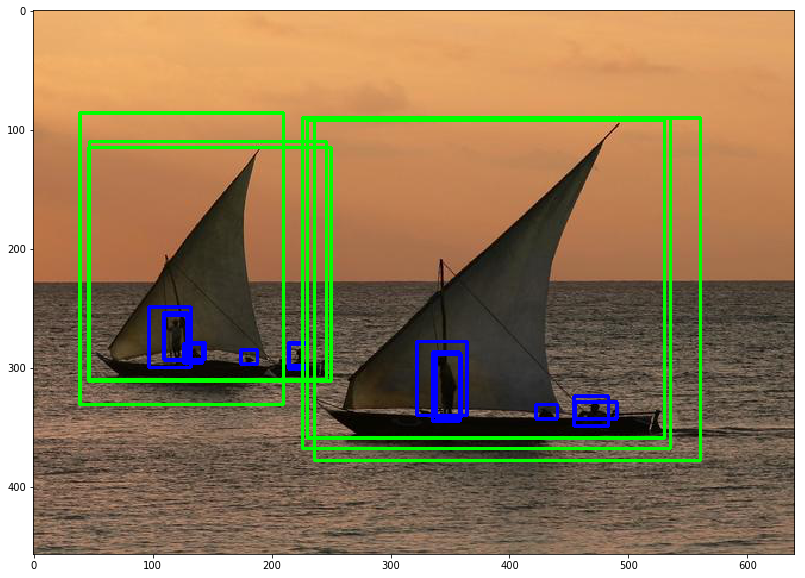

In [119]:
#15,16,8,24,32,35,40,44,48,55,68,72,35745,518
# image_no=55
image_no+=1
print(image_no)
input_img = cv2.imread(train_image_path+train_data['name'][image_no])
RGB_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

for i in train_data['human_bbox'][image_no]:
    cv2.rectangle(RGB_img, (i[0],i[2]),(i[1],i[3]), (0,0,255), 2)
for i in train_data['object_bbox'][image_no]:
    cv2.rectangle(RGB_img, (i[0],i[2]),(i[1],i[3]), (0,255,0), 2)

for i in train_data['action_no'][image_no]:
    print(hoi_dict[str(i)])
print(train_data.iloc[image_no])
plt.figure(figsize=(20,10))
plt.imshow(RGB_img)

In [11]:
action_no=train_data.action_no.tolist()
obj_list = []
obj_id_list = [] 
for i in tqdm(action_no):
    obj_sub_list = []
    obj_id_sub_list = []
    for j in range(len(i)):
        obj_item=hoi_dict[str(i[j])][1]
        obj_id = obj_word_to_id[obj_item.replace('_'," ")]
        if obj_item not in obj_sub_list:
            obj_sub_list.append(obj_item)
        if obj_id not in obj_id_sub_list:
            obj_id_sub_list.append(obj_id)
    obj_list.append(obj_sub_list)
    obj_id_list.append(obj_id_sub_list)
train_data['obj_list']=obj_list
train_data['obj_id']=obj_id_list        

HBox(children=(IntProgress(value=0, max=38118), HTML(value='')))

# Create simple training data

In [13]:
multi_obj_index =[]
for i in range(len(obj_list)):
    if len(obj_list[i])>1:
        multi_obj_index.append(i)
train_data_simple = train_data.drop(multi_obj_index,axis=0)
train_data_simple = train_data_simple.reset_index().drop('index',axis=1)

In [15]:
invis_index=[]
for i in range(len(train_data_simple.invisible.tolist())):
    if np.max(train_data_simple.invisible[i])>0:
        invis_index.append(i)
train_data_simple = train_data_simple.drop(invis_index,axis=0)
train_data_simple = train_data_simple.reset_index().drop('index',axis=1)

In [17]:
train_data_simple.pair_no = [np.array(item) for item in train_data_simple.pair_no.tolist()]

In [18]:
plural_obj_index=[]
for i in range(len(train_data_simple.pair_no.tolist())):
    if np.max(train_data_simple.pair_no[i])>1:
        plural_obj_index.append(i)
train_data_simple = train_data_simple.drop(plural_obj_index,axis=0)
train_data_simple = train_data_simple.reset_index().drop('index',axis=1)

In [21]:
train_data_simple.human_bbox = [np.array(item) for item in train_data_simple.human_bbox.tolist()]
train_data_simple.human_bbox = [np.mean(item,axis=0).astype('int64') for item in train_data_simple.human_bbox.tolist()]
train_data_simple.object_bbox = [np.array(item) for item in train_data_simple.object_bbox.tolist()]
train_data_simple.object_bbox = [np.mean(item,axis=0).astype('int64') for item in train_data_simple.object_bbox.tolist()]

In [23]:
train_data_simple = train_data_simple.drop(['pair_no','invisible'],axis=1)

In [24]:
train_data_simple.head()

,name,size,action_no,human_bbox,object_bbox,obj_list,obj_id
0,HICO_train2015_00000001.jpg,"[640, 480, 3]","[153, 154, 155, 156]","[209, 434, 28, 320]","[64, 576, 103, 399]",[motorcycle],[3]
1,HICO_train2015_00000002.jpg,"[640, 480, 3]",[224],"[262, 638, 1, 138]","[162, 258, 131, 165]",[banana],[46]
2,HICO_train2015_00000003.jpg,"[599, 640, 3]",[65],"[567, 580, 361, 390]","[74, 510, 52, 484]",[bus],[5]
3,HICO_train2015_00000004.jpg,"[640, 427, 3]","[48, 49]","[222, 484, 29, 370]","[265, 365, 87, 122]",[bottle],[39]
4,HICO_train2015_00000005.jpg,"[640, 425, 3]",[242],"[82, 203, 154, 272]","[1, 313, 176, 422]",[bed],[59]


In [26]:
train_data_simple.to_json('train_data_simple.json')

In [46]:
image_no= -1

22595
['hold', 'knife']
['wield', 'knife']
action_no                       [378, 381]
human_bbox              [27, 619, 15, 551]
name           HICO_train2015_00032248.jpg
obj_id                                [43]
obj_list                           [knife]
object_bbox            [76, 526, 234, 301]
size                         [640, 566, 1]
Name: 22595, dtype: object


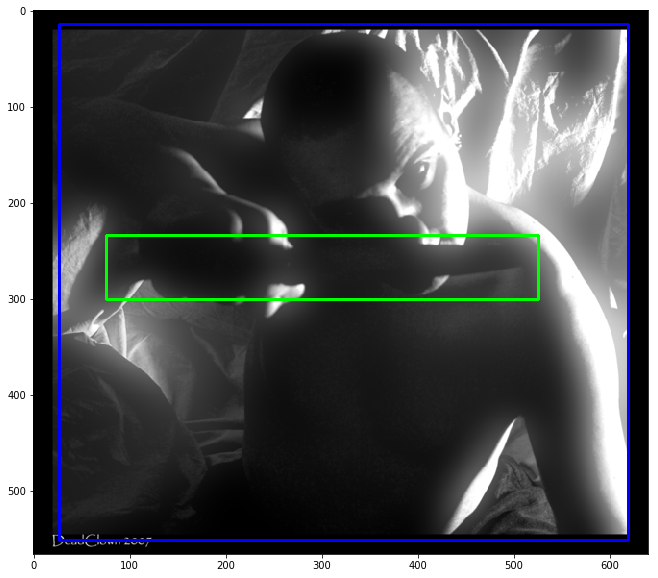

In [48]:
#15,16,8,24,32,35,40,44,48,55,68,72,35745,518
image_no=22595
# image_no+=1
print(image_no)
input_img = cv2.imread(train_image_path+train_data_simple['name'][image_no])
RGB_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
bbox_h = train_data_simple['human_bbox'][image_no]
cv2.rectangle(RGB_img, (bbox_h[0],bbox_h[2]),(bbox_h[1],bbox_h[3]), (0,0,255), 2)
bbox_o = train_data_simple['object_bbox'][image_no]
cv2.rectangle(RGB_img, (bbox_o[0],bbox_o[2]),(bbox_o[1],bbox_o[3]), (0,255,0), 2)

for i in train_data_simple['action_no'][image_no]:
    print(hoi_dict[str(i)])
print(train_data_simple.iloc[image_no])

plt.figure(figsize=(20,10))
plt.imshow(RGB_img)

# Create testing data

In [7]:
action_no=test_data.action_no.tolist()
obj_list = []
obj_id_list = [] 
for i in tqdm(action_no):
    obj_sub_list = []
    obj_id_sub_list = []
    for j in range(len(i)):
        obj_item=hoi_dict[str(i[j])][1]
        obj_id = obj_word_to_id[obj_item.replace('_'," ")]
        if obj_item not in obj_sub_list:
            obj_sub_list.append(obj_item)
        if obj_id not in obj_id_sub_list:
            obj_id_sub_list.append(obj_id)
    obj_list.append(obj_sub_list)
    obj_id_list.append(obj_id_sub_list)
test_data['obj_list']=obj_list
test_data['obj_id']=obj_id_list        

HBox(children=(IntProgress(value=0, max=9658), HTML(value='')))

In [9]:
test_data.to_json('test_data_with_obj_id.json')